In [1]:
import pinocchio
import numpy as np
import math

In [3]:
#model_amir = pinocchio.buildModelFromUrdf("/home/carlos/reach_bravo_7_ws/src/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
model_amir = pinocchio.buildModelFromUrdf("/home/medusa/bravo7_compliance/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
data_amir = model_amir.createData()
tool_link = "EE"

In [4]:
q_vel = np.array([3, 0.2, 0.5, 0.2, 0.1, 0.2])
home = np.array([0.323, 2.708, 0.5045, 1.9917, 1.6112, 0.2304])

## COMPUTE ALL JOINT SPACE DYNAMIC TERMS

In [6]:
pinocchio.computeAllTerms(model_amir, data_amir, home, q_vel)

M_joint_space = pinocchio.crba(model_amir, data_amir, home)
M_joint_space = (M_joint_space + M_joint_space.T) / 2.0            # CRBA can give slight asymmetry -> symmetrize
print("Joint-space mass matrix M(q):")
print(M_joint_space)

Joint-space mass matrix M(q):
[[ 3.46866784e-01  2.28480691e-02 -5.07668207e-02 -7.01790894e-02
  -1.80766761e-02  3.18152494e-06]
 [ 2.28480691e-02  3.88890737e-01  1.55895861e-02 -1.53121738e-02
  -4.05652043e-02 -9.43442899e-04]
 [-5.07668207e-02  1.55895861e-02  1.44153659e-01  5.26938884e-02
  -2.55936564e-02 -9.43442899e-04]
 [-7.01790894e-02 -1.53121738e-02  5.26938884e-02  4.20472073e-02
  -6.78357254e-05  2.69865210e-05]
 [-1.80766761e-02 -4.05652043e-02 -2.55936564e-02 -6.78357254e-05
   2.52991382e-02 -2.44538122e-06]
 [ 3.18152494e-06 -9.43442899e-04 -9.43442899e-04  2.69865210e-05
  -2.44538122e-06  1.03500000e-03]]


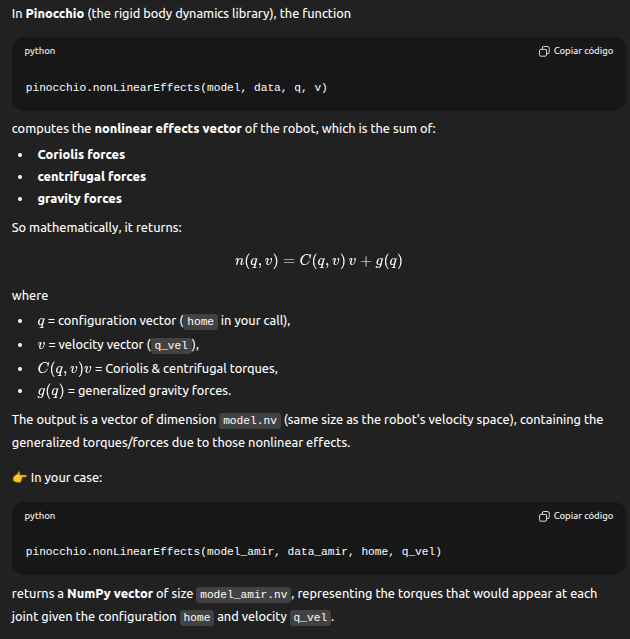

In [10]:
pinocchio.nonLinearEffects(model_amir, data_amir, home, q_vel)

array([ 3.37804812e-01,  1.17713839e+01,  2.09859387e+00, -3.99133458e-01,
       -1.65619565e+00,  6.99130056e-04])

In [11]:
import numpy as np

import pinocchio

g = pinocchio.computeGeneralizedGravity(model_amir, data_amir, home)
C = pinocchio.computeCoriolisMatrix(model_amir, data_amir, home, q_vel)
coriolis = C @ q_vel
nle = pinocchio.nonLinearEffects(model_amir, data_amir, home, q_vel)

print("Gravity:\n", g)
print("Coriolis * v:\n", coriolis)
print("Nonlinear effects (should be sum):\n", nle)
print("Check:", np.allclose(nle, g + coriolis))

Gravity:
 [-3.18735094e-05  1.00238449e+01  3.52623230e+00  1.83892639e-01
 -1.71705554e+00  0.00000000e+00]
Coriolis * v:
 [ 3.37836685e-01  1.74753899e+00 -1.42763843e+00 -5.83026097e-01
  6.08598883e-02  6.99130056e-04]
Nonlinear effects (should be sum):
 [ 3.37804812e-01  1.17713839e+01  2.09859387e+00 -3.99133458e-01
 -1.65619565e+00  6.99130056e-04]
Check: True


## COMPUTE ALL TASK SPACE DYNAMIC TERMS

#### Joint Space Dynamic Model
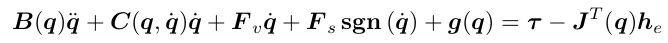
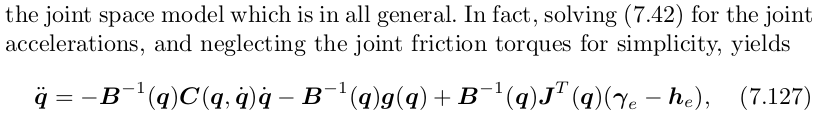

#### Task Space Dynamic Model
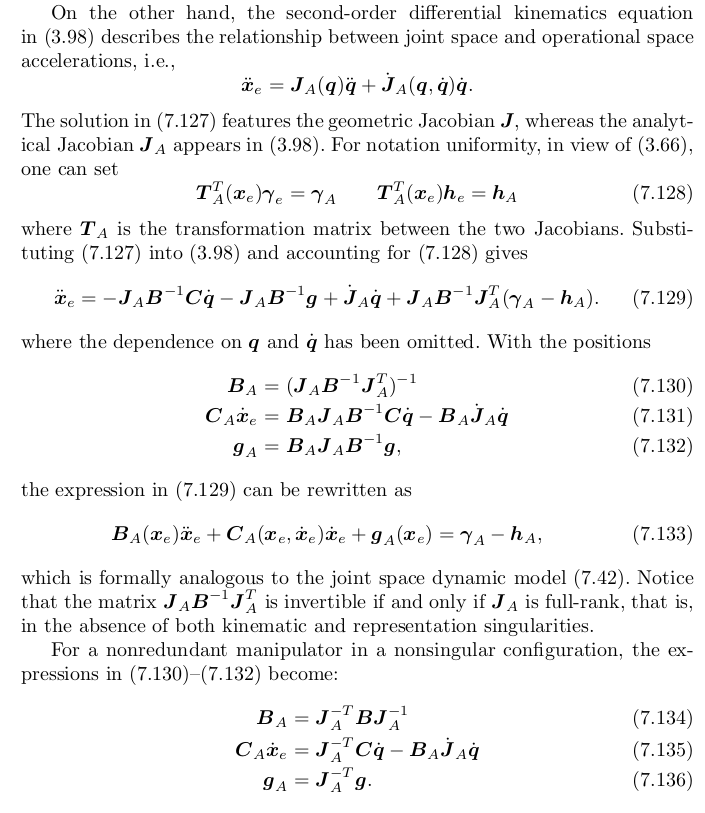

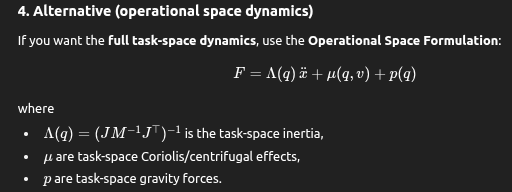

In [14]:

pinocchio.forwardKinematics(model_amir, data_amir, home)
J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, 43)
M = pinocchio.crba(model_amir, data_amir, home)   # Mass matrix
M_inv = np.linalg.inv(M)

M_task_space = np.linalg.inv(J @ M_inv @ J.T)     # Task-space inertia
M_task_space

array([[ 7.14841769e+00,  2.45902668e+00,  5.92082308e-01,
         5.88837343e-01, -1.39273668e+00, -1.76231186e-05],
       [ 2.45902668e+00,  4.68635971e+00, -3.24308646e-01,
         9.20338455e-01, -5.53936234e-01, -7.00928188e-06],
       [ 5.92082308e-01, -3.24308646e-01,  5.15930764e+00,
        -1.09481875e-01, -1.67219645e-03, -2.11592880e-08],
       [ 5.88837343e-01,  9.20338455e-01, -1.09481875e-01,
         2.02513369e-01, -1.33339713e-01, -1.66872260e-05],
       [-1.39273668e+00, -5.53936234e-01, -1.67219645e-03,
        -1.33339713e-01,  2.92795339e-01,  2.69181565e-06],
       [-1.76231186e-05, -7.00928188e-06, -2.11592880e-08,
        -1.66872260e-05,  2.69181565e-06,  1.03500002e-03]])

In [16]:
## Based on pag 198 of Handbook of Robotics 9.2, the task space coriolis term is:

J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, 43)
dJ = pinocchio.getFrameJacobianTimeVariation(model_amir, data_amir, 43, pinocchio.ReferenceFrame.LOCAL)
invJT = np.linalg.inv(J.T)
invJ = np.linalg.inv(J)

#! CAREFUL AT CALCULATING THE JACOBIAN (GLOBAL OR LOCAL FRAME)
Coriolis_task_space = invJT @ (C @ invJ) - M_task_space @ dJ @ invJ
Coriolis_task_space  



array([[-2.59474632e+00,  5.96280650e-02, -5.20375348e+00,
         1.74016680e-01,  3.63434895e-01,  4.59875609e-06],
       [-2.36068166e+00, -4.11834767e-01, -1.24502489e+01,
        -6.18058072e-02,  3.20270522e-01,  4.05257181e-06],
       [ 5.84587795e+00,  1.33083346e+01, -7.88308061e-01,
         2.59686672e+00, -1.36546229e+00, -1.72779997e-05],
       [-7.76184605e-01, -1.68300694e-01, -2.39364395e+00,
        -3.15095445e-02,  1.14080750e-01,  1.36364529e-04],
       [ 8.15755051e-01,  2.29968883e-01,  1.15675031e+00,
         2.93789267e-02, -1.35157070e-01, -1.46063063e-03],
       [ 1.03222298e-05,  2.90993192e-06,  1.46370439e-05,
        -1.34549249e-04,  1.45721019e-03, -2.16404677e-11]])

In [18]:
#verification that nle = g + coriolis
g = pinocchio.computeGeneralizedGravity(model_amir, data_amir, home)
C = pinocchio.computeCoriolisMatrix(model_amir, data_amir, home, q_vel)
coriolis = C @ q_vel
nle = pinocchio.nonLinearEffects(model_amir, data_amir, home, q_vel)
print(np.allclose(nle, g + coriolis))  # Should be True

True


## How to Verify Task-Space Coriolis Matrix
To verify your task-space Coriolis matrix $C_{task}$:
1. **Physical check:** For zero joint velocity, $C_{task} \dot{x} = 0$.
2. **Numerical check:** Compare $C_{task}$ with the transformation from joint-space Coriolis using the Jacobian:
   - $C_{task} = J^{-T} C J^{-1} - M_{task} \dot{J} J^{-1}$ (Handbook of Robotics Eq. 9.2)
3. **Consistency check:** The sum of task-space gravity and Coriolis should match the task-space nonlinear effects if you transform all terms.
4. **Simulation check:** Apply $C_{task}$ in a simulation and verify the resulting forces match expected behavior for given velocities.

You can numerically compare your $C_{task}$ against a finite-difference derivative of the task-space momentum:
$$\frac{d}{dt}(M_{task} \dot{x})$$
and see if it matches $C_{task} \dot{x}$ for your configuration.